<a href="https://colab.research.google.com/github/bartekf4/ja/blob/master/Copy_of_PSI_Analiza_skupien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analiza skupień z scikit-learn

# Podstawy Sztucznej Inteligencji (Uczenie nienadzorowane)

Algorytmy klasteryzacji (grupowania) są jedną z grup metod uczenia nienadzorowanego i pozwalają na automatyczne grupowanie wielowymiarowych danych w klastry.

Na tych zajęciach użyjemy scikit-learn do określenia klastrów przy użyciu różnych algorytmów.
Eksperymentując z każdym z algorytmów klasteryzacji, spróbujemy odkryć wady i zalety poszczególnych algorytmów:

* K-Means (Algorytm centroidów)
* MeanShift
* DBSCAN (Analiza gęstościowa)
* AgglomerativeClustering (Algorytmy aglomeracyjne)

Aby pomóc w zrozumieniu tematu, stworzymy wizualizację, która pokaże, jak wygląda klastrowanie przy dwóch/trzech wymiarach.

W końcu, ponieważ możemy grać z tymi samymi danymi, które są używane do uczenia nadzorowanego, możemy sprawdzić, jak nienadzorowane grupowanie może tworzyć grupy klientów o podobnych atrybutach.

Spróbujemy użyć także metod grupowania do zmniejszenia liczby kolorów na rysunku (pogrupowania podobnych kolorystycznie punktów), jak i stworzenia grup klientów o podobnych atrybutach. 

## Importowanie modułów

Zaimportuj moduły Pythona, których będziemy potrzebowali do pozostałej części notebooka.


In [1]:
%matplotlib inline
from time import sleep
from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.animation
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import lines
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs # Datasets
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles 
from sklearn.model_selection import train_test_split  # Cross validation library

Zaimportuj dodatkowe funkcje pomocne przy wizualizacji danych:

In [2]:
!wget -nc https://home.agh.edu.pl/~kluza/i2ai_utilities.py

--2021-12-02 20:27:28--  https://home.agh.edu.pl/~kluza/i2ai_utilities.py
Resolving home.agh.edu.pl (home.agh.edu.pl)... 149.156.98.66, 2001:6d8:10:1127::6242
Connecting to home.agh.edu.pl (home.agh.edu.pl)|149.156.98.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5171 (5.0K)
Saving to: ‘i2ai_utilities.py’

i2ai_utilities.py   100%[===================>]   5.05K  --.-KB/s    in 0s      

2021-12-02 20:27:29 (96.5 MB/s) - ‘i2ai_utilities.py’ saved [5171/5171]



In [3]:
# Additional functions for data visualization
from i2ai_utilities import show_scatter_3d, show_scatter, plotly_scatter_3d, show_risk_by_cluster, plot_dendrogram

Najpierw wygeneruj dwuwymiarowy zbiór danych zawierający trzy różne klastry (plamy). 

Aby podkreślić, że jest to algorytm nienadzorowany, zwróć uwagę, że nie będziemy używać wygenerowanych etykiet do klasteryzacji:

In [4]:
X,y = make_blobs(centers=3, n_samples=200, random_state=0, cluster_std=0.7)
print(X[:10],y[:10])

[[-1.67173659  3.5340075 ]
 [ 0.73273157  4.41323161]
 [ 1.08473328  4.56850109]
 [-1.45849654  3.32594984]
 [ 1.1850368   5.23225746]
 [-0.98562693  2.08916581]
 [ 2.42001293  0.49461208]
 [ 1.70664481  2.2483361 ]
 [ 1.06510854  4.58517988]
 [-1.66036146  2.6414876 ]] [2 0 0 2 0 2 1 1 0 2]


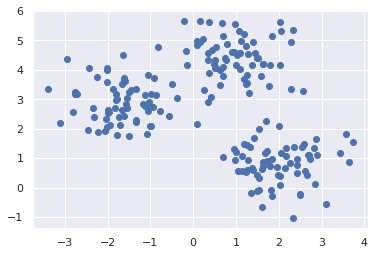

In [5]:
show_scatter(X)

Na oko dość łatwo jest wyodrębnić klastry w wygenerowanych danych.

Zapewne zauważyliście trzy klastry (poniżej wizualizacja z wygenerowanymi etykietami, których nie będziemy już potem używać).

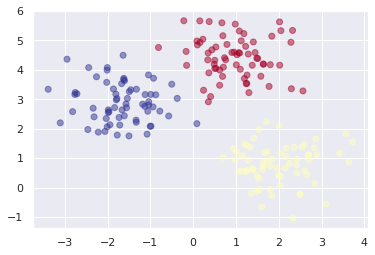

In [6]:
show_scatter(X, y)

W bibliotece scikit-learn znajduje się implementacja analizy centroidowej, a konkretniej algorytmu z rodziny k-średnich (k-means). 

Zastosuj go do wcześniejszego zbioru losowo wygenerowanych plamek (zakładając, że zapomnieliśmy o ich etykietach).

184.23754416562906


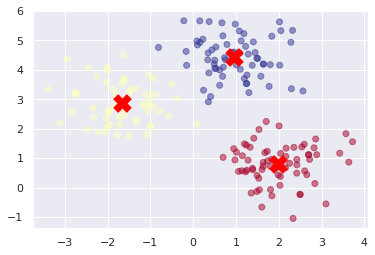

In [7]:
k = 3
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_
print(kmeans.inertia_)
show_scatter(X, y_pred, centers)

Jak dobrać liczbę klastrów?

In [8]:
km_list = list()

for k in range(1,10):
    km = KMeans(n_clusters=k)
    y_pred = km.fit(X)
    km_list.append(pd.Series({'clusters': k, 
                              'inertia': km.inertia_}))

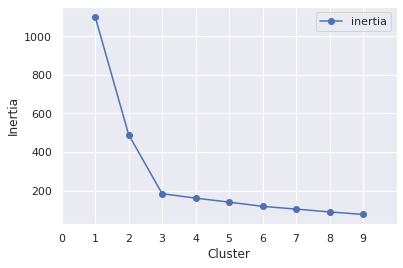

In [9]:
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,10,1))
ax.set_xlim(0,10)
ax.set(xlabel='Cluster', ylabel='Inertia');

Wypróbujmy teraz inny algorytm klasteryzacji — MeanShift.

Na podstawie obserwacji kodu, co możesz powiedzieć o tym algorytmie? 

Number of clusters:  3


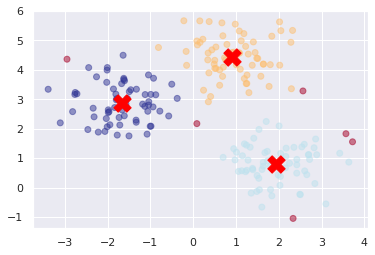

In [10]:
ms = MeanShift(cluster_all=False)
y_pred = ms.fit_predict(X)
centers = ms.cluster_centers_
print("Number of clusters: ", len(centers))
show_scatter(X, y_pred, centers)

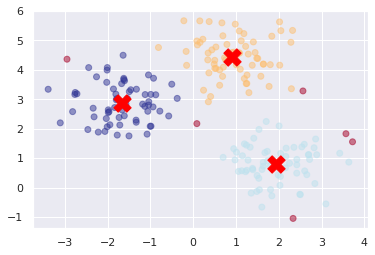

In [11]:
# Additionally you can play with the bandwidth attribute
bandwidth = estimate_bandwidth(X, quantile=.3, n_samples=1000) 
ms = MeanShift(cluster_all=False, bandwidth=bandwidth)
y_pred = ms.fit_predict(X)
centers = ms.cluster_centers_
show_scatter(X, y_pred, centers)

A teraz zastosujmy analizę gęstościową przy użyciu algorytmy DBSCAN.

Number of clusters: 3
Number of outliers: 12


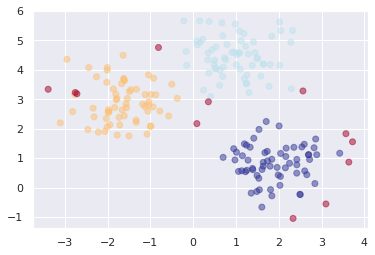

In [12]:
dbscan = DBSCAN(eps=0.6)
y_pred = dbscan.fit_predict(X)
print('Number of clusters:', len(set(y_pred))-(1 if -1 in y_pred else 0))
print('Number of outliers:', list(y_pred).count(-1))
show_scatter(X, y_pred)

Na koniec zobaczmy, jak poradzi sobie z naszymi danymi algorytm aglomeratywny:

In [13]:
ac = AgglomerativeClustering(n_clusters=None, distance_threshold=4, 
                             affinity='euclidean', linkage='complete')
y_pred = ac.fit_predict(X)
print('Number of clusters:', len(set(y_pred)))

Number of clusters: 3


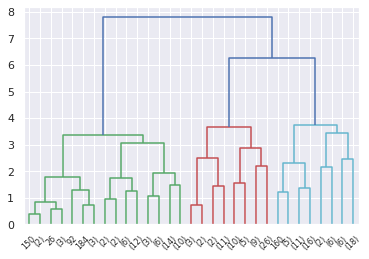

In [14]:
plot_dendrogram(ac, truncate_mode='level', p=4)

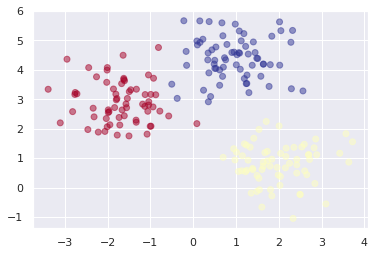

In [15]:
show_scatter(X, y_pred)

## Ćwiczenie 1


Poeksperymentuj z innymi typami zbiorów danych (patrz: księżyce i koła poniżej) i spróbuj określić, jaki typ algorytmu klasteryzacji sprawdzi się dla nich najlepiej. Pamiętaj o sprawdzeniu parametrów dla różnych algorytmów, np.:
  * k dla KMeans,
  * eps dla DBSCAN, 
  * distance_threshold, affinity lub linkage dla AgglomerativeClustering.

**W raporcie zamieść swoje najlepsze wyniki dla każdego zbioru danych, ich porównanie oraz spostrzeżenia/wnioski dotyczące tych czterech algorytmów grupowania (wraz z wykresami ilustrującymi wyniki).**

78.21259529662535


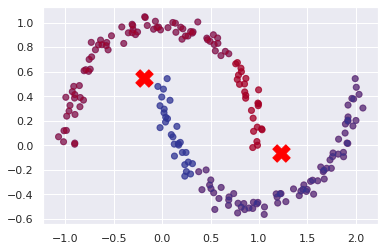

In [16]:
X, y = make_moons(n_samples=200, noise=0.05)
kmeans = KMeans(n_clusters=2)
y_pred = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_
print(kmeans.inertia_)
show_scatter(X, y_pred, centers)
show_scatter(X,y)

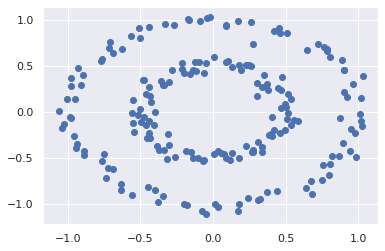

In [17]:
X, y  = make_circles(n_samples=200, factor=0.5, noise=0.05)
show_scatter(X)

## Ćwiczenie 2

Klasteryzacji możemy użyć do różnych celów. Niezbyt typowym, ale możliwym jest np. kompresja kolorów obrazu.

Spróbuj użyć tej techniki dla obrazu z modułu scikit-learn datasets:

NameError: ignored

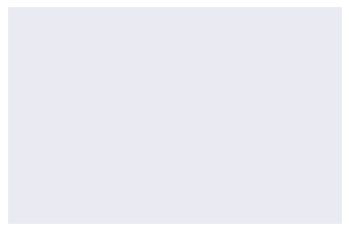

In [19]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
china = load_sample_image("jb.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(jb);

Obraz przechowywany jest w trójwymiarowej tablicy o rozmiarze (wysokość, szerokość, RGB), zawierającej składowe czerwony/niebieski/zielony w postaci liczb całkowitych od 0 do 255:

In [ ]:
china.shape

Przekształć dane na `[n_samples x n_features]`, i przeskaluj kolory, tak aby mieściły się w przedziale od 0 do 1:

In [ ]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(740* 1200, 3)
data.shape

Zwizualizuj piksele w tej przestrzeni kolorów, używając podzbioru 10 000 pikseli dla zwiększenia wydajności:

In [ ]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

In [ ]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Zredukuj 16 milionów kolorów do zaledwie 16 kolorów, używając metody k-średnich w przestrzeni pikseli (dla szybszych obliczeń możesz użyć MiniBatchKMeans zamiast KMeans):

In [ ]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

W rezultacie otrzymujemy nowy obraz, w którym każdemu pikselowi przypisany jest kolor najbliższego mu centrum klastra. Zaprezentujmy zatem te nowe kolory w przestrzeni obrazu, aby zobaczyć działanie algorytmu k-średnich w tym wypadku:

In [ ]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

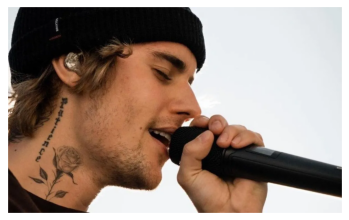

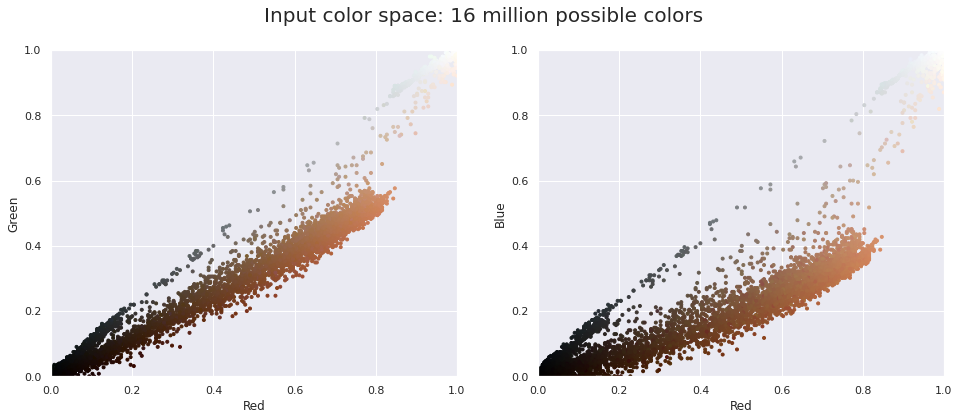

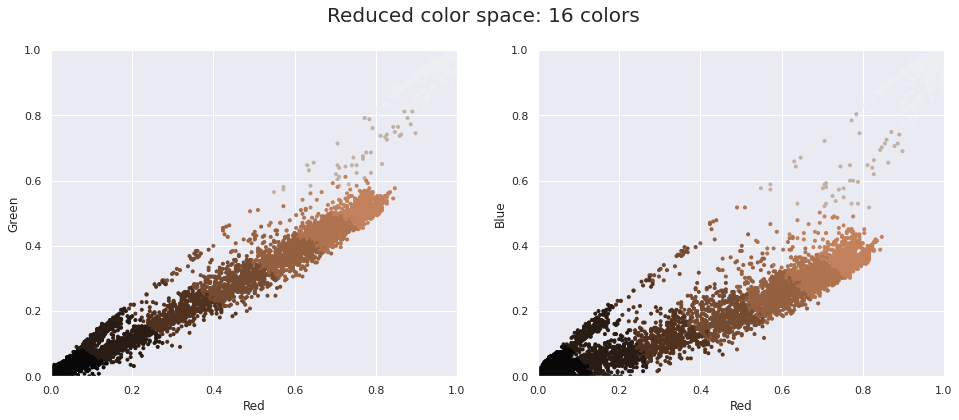

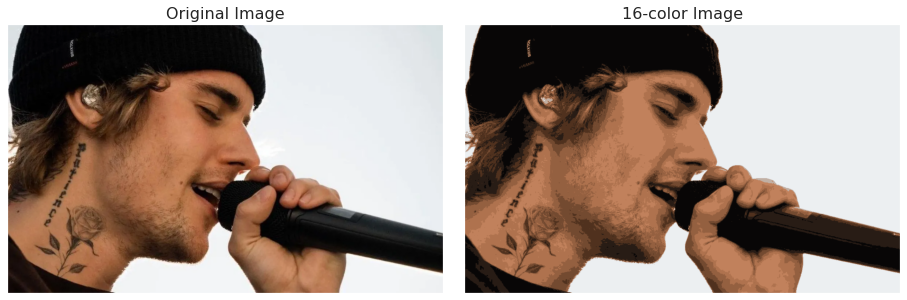

In [21]:
from sklearn.datasets import load_sample_image

jb = load_sample_image("jb.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(jb);
data = jb / 255.0  # use 0...1 scale
data = data.reshape(740 * 1200, 3)
data.shape


def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data

    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);
plot_pixels(data, title='Input color space: 16 million possible colors')
kmeans = KMeans(n_clusters=9)


kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")
jb_recolored = new_colors.reshape(jb.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(jb)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(jb_recolored)
ax[1].set_title('16-color Image', size=16);

**Do raportu wybierz i użyj innego obrazu. Następnie zredukuj jego kolory do mniej niż 10 kolorów, ale w taki sposób, aby obraz bardzo przypominał oryginalny obraz. Umieść w raporcie nazwę obrazu, informację o liczbie kolorów, a także zarówno oryginalny, jak i skompresowany obraz**

Choć udało nam się osiągnąć całkiem niezłą kompresję, warto pamiętać, że istnieją dużo lepsze sposoby kompresji informacji niż klasteryzacja. 

## Ćwiczenie 3



## Wczytaj dane o klientach i aktywności sprzedażowej

Użyj poniższej komórki, aby załadować `merged_customers.csv` do Dataframe pandas.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/IBM/ml-learning-path-assets/master/data/mergedcustomers.csv")

## Przygotuj dane 

Usuń kolumnę `CHURNRISK` z naszych danych.  Nie chcemy używać tej etykiety do grupowania, ale zapiszemy ją, jeśli chcielibyśmy później wypróbować zewnętrzną ocenę naszych klastrów.
Wybierz tylko kilka kolumn liczbowych jako funkcje dla naszych testów klastrów klientów — w tym zyski pomniejszone o straty połączone w jedną kolumnę `PROFIT_YTD`.

In [ ]:
# Save the CHURNRISK label column for later.
known_risk = df['CHURNRISK']

# Combine gains - losses into a profit column,
# and select a some of the numeric trader data to use for our customer clustering example.
keep_columns = ['AGE', 'TOTALUNITSTRADED', 'DAYSSINCELASTTRADE', 'DAYSSINCELASTLOGIN', 'PROFIT_YTD']

df_churn = df.assign(PROFIT_YTD=df.apply(lambda row: row.NETREALIZEDGAINS_YTD - row.NETREALIZEDLOSSES_YTD, axis=1).values)[keep_columns]

# Pick 3 features to use later in 3D charts
x_name = 'AGE'
y_name = 'PROFIT_YTD'
z_name = 'DAYSSINCELASTTRADE'

df_churn.head()

Zbiór danych klienta jest bardziej zbliżony do rzeczywistych danych. Zwizualizuj wybrane trzy cechy, które mogą być ważne. Nie przewidzieliśmy jeszcze klastrów, więc pokażmy tylko kolor etykiety `CHURNRISK`, którą zapisaliśmy.


In [ ]:
# We did not use k-means yet, let's just use the labels for color
label_colors = known_risk.map({'High': 'r', 'Medium': 'b', 'Low': 'g'})

show_scatter_3d(df_churn, x_name, y_name, z_name, predicted=label_colors, show_colorbar=False);

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k)
predicted = kmeans.fit_predict(df_churn.values)
centers = kmeans.cluster_centers_

show_scatter_3d(df_churn, x_name, y_name, z_name, predicted=predicted, centers=centers);


### Ocena zewnętrzna

W naszym przypadku możemy także przeprowadzić „ocenę zewnętrzną”, aby określić, czy nasze klastry dzielą klientów także na podgrupy względem etykiety CHURNRISK, którą usunęliśmy z danych.

Nie powinniśmy oczekiwać, że uczenie nienadzorowane będzie dobrym predyktorem takiej konkretnej cechy (uczenie nadzorowane w takim wypadku powinno działać lepiej), ale to pokazuje, że te odkryte grupy klientów mogą mieć pewne cechy wspólne.

Dla n_clusters = 3, sprawdź, że klienci niskiego ryzyka zostali dość dokładnie pogrupowani. Inny klaster jest w większości przypadków wysokiego ryzyka. Trzecia grupa jest wysoka / średnia.

In [ ]:
show_risk_by_cluster(predicted, known_risk)

#### Wizualizacja 3D

Użyj wykresu Plotly do analizy danych pod różnymi kątami. **Która kolumna ma duży wpływ na podział na klastry?**

In [ ]:
X_df = df_churn.copy()
X_df['CLUSTER'] = predicted
plotly_scatter_3d(X_df, x_name, y_name, z_name, color='CLUSTER')

In [ ]:
ms = MeanShift(cluster_all=False)
predicted = ms.fit_predict(df_churn.values)
labels = ms.labels_
centers = ms.cluster_centers_

print("Number of clusters: ", len(centers))

In [ ]:
show_scatter_3d(df_churn, x_name, y_name, z_name, predicted=predicted, centers=centers,
                show_colorbar=True,
                cmap=ListedColormap(cm.Accent.colors[:6]));

In [ ]:
temp_df = df_churn.copy()
temp_df['CLUSTER'] = predicted
no_outliers_df = temp_df[temp_df['CLUSTER']!=-1]
outliers_df = temp_df[temp_df['CLUSTER']==-1]

In [ ]:
charts = [
    {'dataframe': temp_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': outliers_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:1])},
    {'dataframe': temp_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': no_outliers_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[1:6])},
    {'dataframe': temp_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': no_outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[1:6])},
    {'dataframe': temp_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': no_outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[1:6])},
    {'dataframe': temp_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:1])},
    {'dataframe': temp_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:1])}
]

# n loops for more time to watch charts
loops = 2
for loop in range(loops):
  for chart in charts:
    clear_output(wait=True)
    fig, ax = show_scatter_3d(chart['dataframe'], x_name, y_name, z_name, predicted=chart['dataframe']['CLUSTER'],
                centers=chart['centers'],
                show_colorbar=False, cmap=chart['cmap'],
                elev=35, azim=10,
                xlim3d=(10, 80), ylim3d=(-3000, 3000), zlim3d=(0, 20))
        
    display(fig)
    plt.close(fig)
    sleep(1)

In [ ]:
from sklearn.cluster import DBSCAN
predicted = DBSCAN(eps=110).fit_predict(df_churn)

print('Number of clusters:', len(set(predicted)) - (1 if -1 in predicted else 0))
print('Number of outliers:', list(predicted).count(-1))

In [ ]:
temp_df = df_churn.copy()
temp_df['CLUSTER'] = predicted
temp_df['KNOWN_RISK'] = known_risk
temp_df.columns = [str(x) for x in temp_df.columns.values]
no_outliers_df = temp_df[temp_df['CLUSTER']!=-1]
outliers_df = temp_df[temp_df['CLUSTER']==-1]

In [ ]:
show_scatter_3d(no_outliers_df, x_name, y_name, z_name, predicted=no_outliers_df['CLUSTER'], azim=2);

In [ ]:
show_scatter_3d(outliers_df, x_name, y_name, z_name, predicted=outliers_df['CLUSTER'], cmap=cm.gist_stern, alpha=1, azim=5);

Modyfikując wartości parametrów algorytmu `distance_threshold` -- odległość i `affinity` -- typ metryki: 'manhattan' lub 'euclidean', ew. `linkage`, wybierz parametry, które Twoim zdaniem najlepiej odwzorowują rzeczywiste wartości. 
**Wyniki umieść w swoim raporcie.**


In [ ]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=None, distance_threshold=500, 
                             affinity='euclidean', linkage='complete')
predicted = ac.fit_predict(df_churn.values)

print('Number of clusters:', len(set(predicted)))

In [ ]:
plot_dendrogram(ac, truncate_mode='level', p=3)

In [ ]:
show_scatter_3d(df_churn, x_name, y_name, z_name, predicted=predicted);

In [ ]:
X_df = df_churn.copy()
X_df['CLUSTER'] = predicted
plotly_scatter_3d(X_df, x_name, y_name, z_name, color='CLUSTER')

**W raporcie odpowiedz i uzasadnij (na bazie odpowiednich wykresów lub wyników algorytmów), która kolumna ze zbioru danych `mergedcustomers.csv` silnie wpływa na podział na klastry**.